In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib as mpl
# mpl.use('Agg')
import seaborn as sns
from graph_tool import GraphView
from graph_tool.draw import sfdp_layout, graph_draw
from sklearn.metrics import average_precision_score
from collections import OrderedDict

from helpers import infected_nodes, cascade_source
from graph_helpers import load_graph_by_name, remove_filters, get_edge_weights, extract_edges, extract_nodes
from random_steiner_tree.util import from_gt
from viz_helpers import lattice_node_pos
from sample_pool import TreeSamplePool
from query_selection import PredictionErrorQueryGenerator
from simulator import Simulator
from tree_stat import TreeBasedStatistics
from experiment import gen_input
from root_sampler import build_true_root_sampler

In [3]:
graph = 'lattice-1024'
num_queries_to_show = 10
sampling_method = 'cut'
obs_method = "leaves"
dataset_id = '{}-mic-s0.02-o{}'.format(graph, obs_method)
cascade_dir = 'cascade/{}'.format(dataset_id)


In [4]:
cascade_id = 35

In [5]:
g = load_graph_by_name(graph, weighted=True)
g_norm = load_graph_by_name(graph, weighted=True, suffix="_preprocessed")
g_rev = load_graph_by_name(graph, weighted=True, suffix="_reversed")
g_und = GraphView(g, directed=False)
g_und.set_directed(False)
if graph == 'lattice-1024':
    pos = lattice_node_pos(g, shape=(32, 32))
else:
    pos = sfdp_layout(g)

load graph from data/lattice-1024/graph_weighted.gt
load graph from data/lattice-1024/graph_weighted_preprocessed.gt
load graph from data/lattice-1024/graph_weighted_reversed.gt


In [6]:
if False:
    obs, c, tree = gen_input(g, source=804, p=get_edge_weights(g), model='ic', observation_method='leaves', 
                             min_size=40, max_size=80, return_tree=True)
    pkl.dump((obs, c, tree), open('cascade-weighted/lattice-exapmle.pkl', 'wb'))    
else:
    obs, c, tree = pkl.load(open('cascade-weighted/lattice-exapmle.pkl', 'rb'))
inf_nodes = infected_nodes(c)
hidden_infs = set(inf_nodes) - set(obs)
source = cascade_source(c)

In [7]:
g.num_edges(), g_norm.num_edges()

(3968, 4992)

In [87]:
gv = remove_filters(g_norm)

weights = get_edge_weights(gv)
gi = from_gt(gv, weights=weights)

sampler = TreeSamplePool(
    gv,
    n_samples=1000,
    method='cut',
    gi=gi,
    return_tree_nodes=True,
    with_inc_sampling=False)

params = {'n_node_samples': None,
          'prune_nodes': True,
          'root_sampler': 'true_root',
          'root_sampler_eps': 0.0,
          'min_proba': 0.4,
          'n_node_samples': None,
          'error_estimator': TreeBasedStatistics(gv)}
q_gen = PredictionErrorQueryGenerator(gv, sampler, **params, verbose=True)
sim = Simulator(gv, q_gen, gi=gi, print_log=True)

DEBUG: TreeSamplePool.with_inc_sampling= False


In [88]:
qs = sim.run(10, obs, c)
queries = qs[0]

  0%|          | 0/10 [00:00<?, ?it/s]

pruning candidates from 1002 to 39
no estimation node sampling
update samples started


 10%|█         | 1/10 [00:01<00:11,  1.32s/it]

update samples done
pruning candidates from 38 to 34
no estimation node sampling
update samples started


 20%|██        | 2/10 [00:02<00:10,  1.36s/it]

update samples done
pruning candidates from 33 to 30
no estimation node sampling
update samples started


 30%|███       | 3/10 [00:04<00:10,  1.46s/it]

update samples done
pruning candidates from 29 to 24
no estimation node sampling
update samples started


 40%|████      | 4/10 [00:05<00:08,  1.41s/it]

update samples done
pruning candidates from 23 to 19
no estimation node sampling
update samples started


 50%|█████     | 5/10 [00:07<00:07,  1.44s/it]

update samples done
pruning candidates from 18 to 16
no estimation node sampling
update samples started


 60%|██████    | 6/10 [00:08<00:05,  1.41s/it]

update samples done
pruning candidates from 15 to 13
no estimation node sampling
update samples started


 70%|███████   | 7/10 [00:09<00:04,  1.38s/it]

update samples done
pruning candidates from 12 to 11
no estimation node sampling
update samples started


 80%|████████  | 8/10 [00:11<00:02,  1.40s/it]

update samples done
pruning candidates from 10 to 8
no estimation node sampling
update samples started


 90%|█████████ | 9/10 [00:12<00:01,  1.47s/it]

update samples done
pruning candidates from 7 to 6
no estimation node sampling
update samples started


100%|██████████| 10/10 [00:14<00:00,  1.55s/it]

update samples done


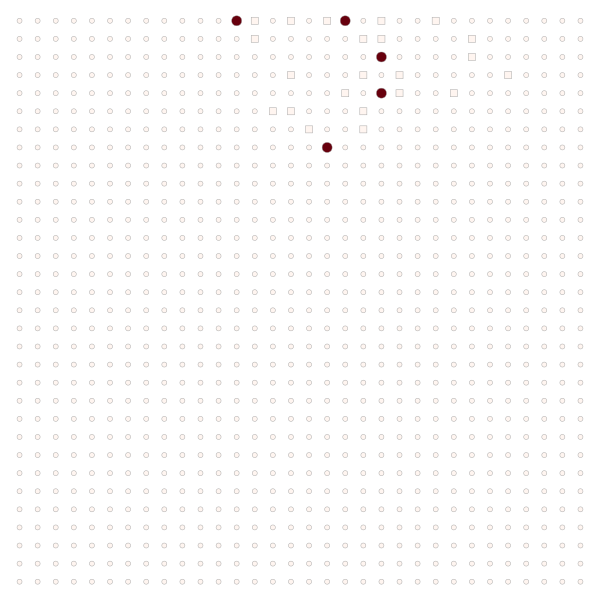

In [89]:
pool_nodes = tuple(q_gen._cand_pool)
node_color_info = {
    pool_nodes: 0.5,
    'default': 0
}
node_shape_info = OrderedDict()
node_shape_info[tuple(obs)] = 'square'
node_shape_info['default'] = 'circle'

node_size_info = {
    pool_nodes: 10,
    tuple(obs): 10,
    'default': 5
}
edge_color_info = {
    'default': 'white'
}
edge_pen_width_info = {
    'default': 2.0
}
visualize(g_und, pos,
          node_color_info,
          node_shape_info,
          node_size_info,
          edge_color_info,
          edge_pen_width_info)

In [50]:
q = queries[0]
q_gen.error_estimator.query_score(q, set(q_gen._cand_pool) - {q})

/home/cloud-user/code/active-network-reconstruction/tree_stat.py:103: RuntimeWarning: invalid value encountered in true_divide
  self._remove_extreme_vals(num1 / denum1))


nan

In [ ]:
# g_norm
# pd.Series([len(t) for t in sampler.samples]).hist()

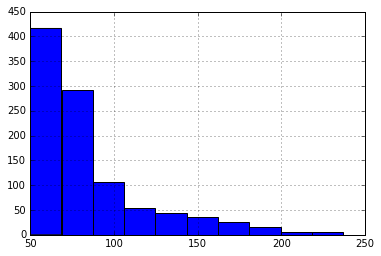

In [51]:
pd.Series([len(t) for t in sampler.samples]).hist()

In [97]:
def visualize(g, pos, 
              node_color_info={},
              node_shape_info={},
              node_size_info={},
              edge_color_info={},
              edge_pen_width_info={},
              output=None):    

    def populate_property(dtype, info, on_edge=False):
        if on_edge:
            prop = g.new_edge_property(dtype)
        else:
            prop = g.new_vertex_property(dtype)
            
        prop.set_value(info['default'])
        del info['default']  
        
        for entries, v in info.items():
            if on_edge:
                for n in entries:
                    prop[g.edge(*n)] = v
            else:
                if dtype not in {'int', 'float'}:
                    for n in entries:
                        prop[n] = v
                else:
                    prop.a[list(entries)] = v

        return prop
        
    vertex_fill_color = populate_property('float', node_color_info)
    vertex_size = populate_property('int', node_size_info)
    vertex_shape = populate_property('string', node_shape_info)
    
    edge_color = populate_property('string', edge_color_info, True)    
    edge_pen_width = populate_property('float', edge_pen_width_info, True)
    
    graph_draw(g, pos=pos,
               vertex_fill_color=vertex_fill_color,
#                vertex_color=vertex_color,
               vertex_size=vertex_size,                
#                vorder=node_order,
               vertex_shape=vertex_shape,
               edge_color=edge_color,
               edge_pen_width=edge_pen_width,
               vcmap=mpl.cm.Reds,
               output=output)

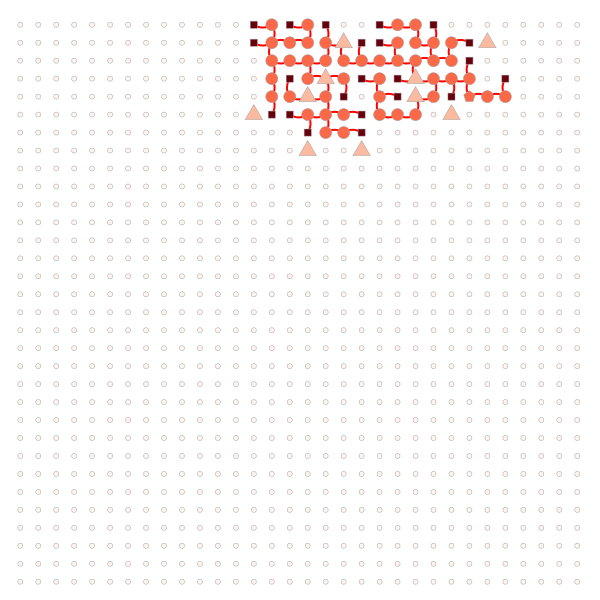

In [99]:
node_color_info = OrderedDict()
node_color_info[tuple(obs)] = 1.0
node_color_info[tuple(hidden_infs)] = 0.5
node_color_info[tuple(queries)] = 0.25
node_color_info['default'] = 0

node_shape_info = OrderedDict()
node_shape_info[tuple(obs)] = 'square'
node_shape_info[tuple(queries)] = 'triangle'
node_shape_info['default'] = 'circle'
node_shape_info[(source, )] = 'pentagon'

node_size_info = OrderedDict()

node_size_info[tuple(obs)] = 10
node_size_info[tuple(hidden_infs)] = 12.5
node_size_info[tuple(queries)] = 20
node_size_info['default'] = 5

edge_color_info = {
    tuple(extract_edges(tree)): 'red',
    'default': 'white'
}
edge_pen_width_info = {
    'default': 2.0
}
visualize(g_und, pos,
          node_color_info,
          node_shape_info,
          node_size_info,
          edge_color_info,
          edge_pen_width_info,
          output='figs/why-prederror-fails/cascade.png')

In [93]:
gv = remove_filters(g)

weights = get_edge_weights(gv)
gi = from_gt(gv, weights=weights)

sampler = TreeSamplePool(
    gv,
    n_samples=25,
    method='cut',
    gi=gi,
    return_tree_nodes=False,
    with_inc_sampling=False)
sampler.fill(obs,
            root_sampler=build_true_root_sampler(c))


DEBUG: TreeSamplePool.with_inc_sampling= False


In [ ]:
# g + loop_erased
sample_sizes =[s.num_vertices() for i, s in enumerate(sampler.samples)]

pd.Series(sample_sizes).hist()

In [ ]:
# g + cut
sample_sizes =[s.num_vertices() for i, s in enumerate(sampler.samples)]

pd.Series(sample_sizes).hist()

In [ ]:
len(inf_nodes)

In [ ]:
# g norm
sample_sizes =[s.num_vertices() for i, s in enumerate(sampler.samples)]

pd.Series(sample_sizes).hist()

In [94]:
sample_id_sizes =[(i, s.num_vertices()) for i, s in enumerate(sampler.samples)]
sorted(sample_id_sizes, key=lambda tpl: abs(tpl[1] - len(inf_nodes)))

[(3, 72),
 (17, 76),
 (19, 78),
 (1, 65),
 (10, 64),
 (14, 84),
 (22, 61),
 (2, 86),
 (4, 91),
 (16, 92),
 (18, 93),
 (21, 93),
 (5, 95),
 (20, 96),
 (6, 99),
 (11, 99),
 (12, 99),
 (23, 104),
 (8, 115),
 (9, 116),
 (0, 117),
 (24, 127),
 (7, 131),
 (15, 187),
 (13, 195)]

804


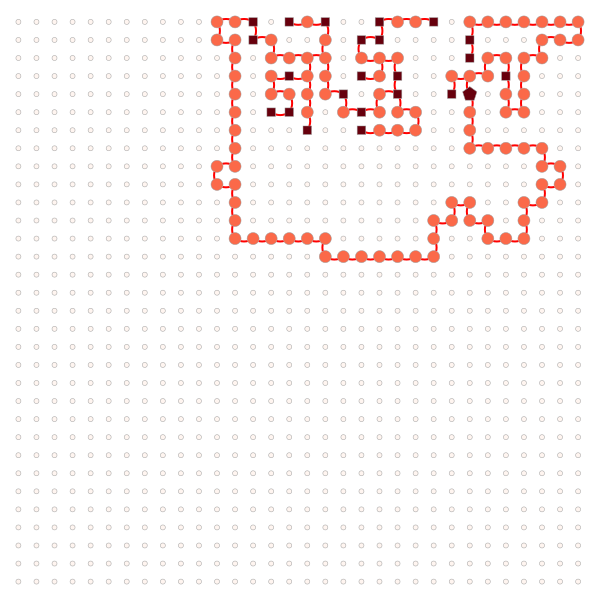

In [100]:
t = sampler.samples[24]
# source = tuple(np.logical_and(t.degree_property_map('out').a > 0, t.degree_property_map('in').a == 0).nonzero()[0])
print(source)
tree_nodes = tuple(extract_nodes(t))
tree_edges = tuple(extract_edges(t))

node_color_info = OrderedDict()
node_color_info[tree_nodes] = 0.5
node_color_info[tuple(obs)] = 1.0
node_color_info[(source, )] = 1.0
node_color_info['default'] = 0

node_shape_info = OrderedDict()
node_shape_info[tuple(obs)] = 'square'
node_shape_info['default'] = 'circle'
node_shape_info[(source, )] = 'pentagon'

node_size_info = {
    tuple(obs): 10,
    tree_nodes: 12.5,
    (source, ): 15,
    'default': 5
}
edge_color_info = {
    tree_edges: 'red',
    'default': 'white'
}
edge_pen_width_info = {
    'default': 2.0
}
visualize(g_und, pos,
          node_color_info,
          node_shape_info,
          node_size_info,
          edge_color_info,
          edge_pen_width_info,
          output='figs/why-prederror-fails/bad-tree.png')

In [ ]:
# what are the pruned nodes
# what's the infection probability and score of the query node